In [1]:
# ================================================================
# Notebook 3 — Forecasting Congestion Income (DK2)
# ================================================================

# ---------------------------------------------------------------
# 0. Standard Library Imports
# ---------------------------------------------------------------
import os
import json
from pathlib import Path

# ---------------------------------------------------------------
# 1. Third-Party Libraries
# ---------------------------------------------------------------
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from IPython.display import Markdown, display
import requests
import joblib

# ---------------------------------------------------------------
# 2. Project Modules (src/*)
# ---------------------------------------------------------------
from src.models.dataset import (
    load_feature_dataset,
    build_supervised,
    time_split
)

from src.models.baselines import (
    naive,
    seasonal_naive,
    rolling_mean
)

from src.models.metrics import evaluate
from src.models.training import train_random_forest
from src.models.diagnostics import compute_residuals
from src.models.plots import plot_residuals, plot_forecast

# ---------------------------------------------------------------
# 3. Notebook Start
# ---------------------------------------------------------------
print("⚡ Notebook 3 — Forecasting Congestion Income (DK2)")

# import plotly.express as px
# from pathlib import Path
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from IPython.display import Markdown, display

# # Our domain modules
# from src.models.dataset import load_feature_dataset, build_supervised, time_split
# from src.models.baselines import naive, seasonal_naive, rolling_mean
# from src.models.metrics import evaluate
# from src.models.training import train_random_forest
# from src.models.diagnostics import compute_residuals
# from src.models.plots import plot_residuals, plot_forecast

# import joblib
# import requests
# import json
# import os

# print("⚡ Notebook 3 — Forecasting Congestion Income (DK2)")


# ---------------------------------------------------------------
# 1. Load dataset (validated)
# ---------------------------------------------------------------

FEATURE_PATH = Path("data/processed/features_congestion_income.parquet")

df = load_feature_dataset(FEATURE_PATH)

print("✔ Dataset successfully loaded.")
print(f"   Rows: {df.shape[0]:,}")
print(f"   Columns: {df.shape[1]}")
print(f"   Time span: {df.index.min()} → {df.index.max()}")

display(df.head(3))


⚡ Notebook 3 — Forecasting Congestion Income (DK2)
✔ Dataset successfully loaded.
   Rows: 356
   Columns: 42
   Time span: 2024-12-31 23:00:00+00:00 → 2025-01-15 04:45:00+00:00


,RevenueEUR,hour,minute,day_of_week,is_weekend,day_of_month,month,quarter,week_of_year,is_month_end,...,zscore_3h,roll_iqr_3h,roll_mean_6h,roll_std_6h,roll_min_6h,roll_max_6h,roll_volnorm_6h,zscore_6h,roll_iqr_6h,hl_vol
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-12-31 23:00:00+00:00,130.13,23,0,1,0,31,12,4,1,1,...,-1.009673,15.785,83.97,78.90408,-74.63,132.23,0.93967,-2.010035,26.7,0.277868
2024-12-31 23:15:00+00:00,114.81,23,15,1,0,31,12,4,1,1,...,-1.009673,15.785,83.97,78.90408,-74.63,132.23,0.93967,-2.010035,26.7,0.277868
2024-12-31 23:30:00+00:00,98.56,23,30,1,0,31,12,4,1,1,...,-1.009673,15.785,83.97,78.90408,-74.63,132.23,0.93967,-2.010035,26.7,0.277868


In [2]:
# ---------------------------------------------------------------
# 2. Build supervised dataset
# ---------------------------------------------------------------

HORIZON = 1   # 15-min ahead forecasting

df_super = build_supervised(df, horizon=HORIZON)

print(f"✔ Target column created (horizon={HORIZON}).")
print(f"Supervised dataset shape: {df_super.shape}")

df_super[["RevenueEUR", "target"]].head(3)


✔ Target column created (horizon=1).
Supervised dataset shape: (355, 43)


,RevenueEUR,target
Timestamp,,
2024-12-31 23:00:00+00:00,130.13,114.81
2024-12-31 23:15:00+00:00,114.81,98.56
2024-12-31 23:30:00+00:00,98.56,102.72


In [3]:
# ---------------------------------------------------------------
# 3. Train-test split (time-respecting)
# ---------------------------------------------------------------

X_train, X_test, y_train, y_test = time_split(
    df_super, 
    target="target",
    ratio=0.8
)

print(f"✔ Train: {len(X_train)} rows | Test: {len(X_test)} rows")
print(f"✔ Features: {X_train.shape[1]}")

# --- Safety checks ---
if not X_train.index.is_monotonic_increasing:
    print("⚠️ Train index is not time-sorted!")

if not X_test.index.is_monotonic_increasing:
    print("⚠️ Test index is not time-sorted!")

if X_train.index.max() >= X_test.index.min():
    print("⚠️ Time leakage: overlap between train and test.")
else:
    print("✔ Time split integrity OK.")

if y_train.isna().any() or y_test.isna().any():
    print("⚠️ Missing values found in target after split.")
else:
    print("✔ Target column OK.")



✔ Train: 284 rows | Test: 71 rows
✔ Features: 42
✔ Time split integrity OK.
✔ Target column OK.


In [4]:
#4

from src.models.baselines import compute_baselines

print("📈 Computing baselines...")

baseline_preds, baseline_metrics, baseline_df = compute_baselines(
    df_super=df_super,
    y_test=y_test,
    y_train=y_train
)

print("✔ Baselines computed and evaluated.")
display(baseline_df)


📈 Computing baselines...
✔ Baselines computed and evaluated.


,Naive,Seasonal Naive,Rolling Mean
MAE,13384.814225,31975.273662,24903.449454
RMSE,22795.531102,44624.924107,37102.994901
MAPE,73.015864,220.040412,264.738423
MASE,5.096755,12.175749,9.482895


In [5]:
# ---------------------------------------------------------------
# 5. Random Forest Model
# ---------------------------------------------------------------

print("🌲 Training Random Forest model...")

rf = train_random_forest(X_train, y_train)

# Predictions aligned with y_test index
y_pred_rf = pd.Series(
    rf.predict(X_test),
    index=y_test.index,
    name="rf_pred"
)

# Evaluate with correct positional order
rf_results = evaluate(
    y_test,        # y_true
    y_pred_rf,     # y_pred
    y_train,       # insample series
    "RandomForest" # name
)

rf_results_df = pd.DataFrame(rf_results, index=[0]).T
rf_results_df.columns = ["RandomForest"]

print("✔ Random Forest trained and evaluated.")
display(rf_results_df)



🌲 Training Random Forest model...
✔ Random Forest trained and evaluated.


,RandomForest
MAE,22924.017826
RMSE,38749.436419
MAPE,85.128299
MASE,8.729154


🔍 Residual diagnostics...
✔ Residual statistics computed:


,mean,std,max_abs_error,skewness,lag1_autocorr
0,19640.919855,33640.636437,163791.290183,2.450914,0.769729


Residuals shape: (71,)


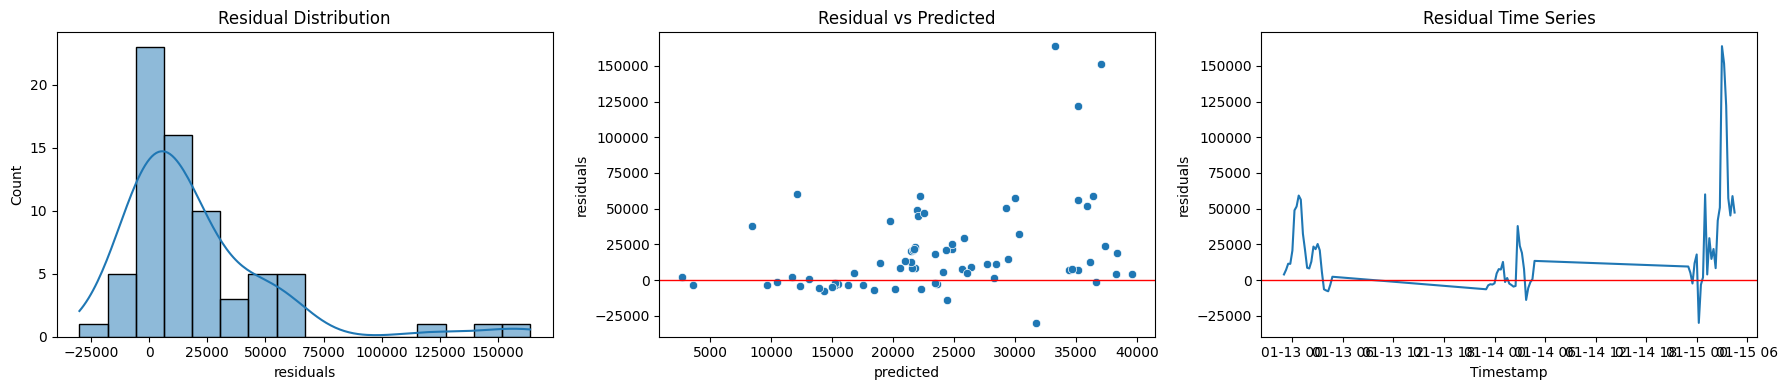

In [6]:
# ---------------------------------------------------------------
# 6. Residual Diagnostics
# ---------------------------------------------------------------

print("🔍 Residual diagnostics...")

# Compute residuals using module function
residuals = compute_residuals(y_test, y_pred_rf)

# ---------------------------------------------------------------
# Residual Statistics (needed for Cell 11)
# ---------------------------------------------------------------
residual_stats = {
    "mean": float(residuals.mean()),
    "std": float(residuals.std()),
    "max_abs_error": float(residuals.abs().max()),
    "skewness": float(residuals.skew()),
    "lag1_autocorr": float(residuals.autocorr(lag=1))
}

print("✔ Residual statistics computed:")
display(pd.DataFrame(residual_stats, index=[0]))

print(f"Residuals shape: {residuals.shape}")

# Plot diagnostic visuals
axes = plot_residuals(y_test, y_pred_rf)

plt.show()



📊 Plotting residuals with volatility overlay...


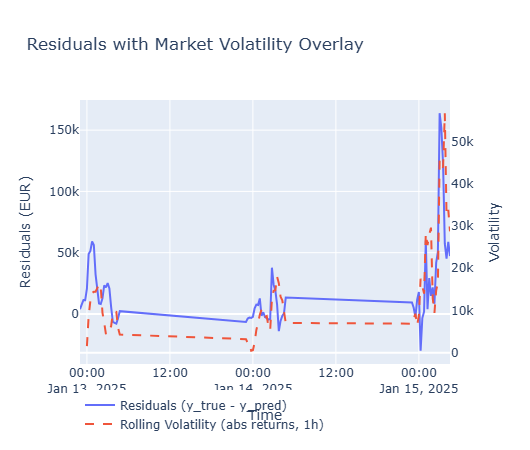

In [7]:
# ---------------------------------------------------------------
# NEW DIAGRAM — Residuals + Volatility Overlay
# ---------------------------------------------------------------

import plotly.graph_objects as go
import numpy as np

print("📊 Plotting residuals with volatility overlay...")

# 1) Rolling volatility (absolute returns)
vol = (y_test.diff().abs().rolling(4).mean())  # 1-hour volatility in 15-min data

fig = go.Figure()

# --- True vs forecast errors ---
fig.add_trace(go.Scatter(
    x=y_test.index,
    y=y_test - y_pred_rf,
    mode="lines",
    name="Residuals (y_true - y_pred)",
    line=dict(width=2)
))

# --- Volatility overlay ---
fig.add_trace(go.Scatter(
    x=y_test.index,
    y=vol,
    mode="lines",
    name="Rolling Volatility (abs returns, 1h)",
    line=dict(width=2, dash="dash"),
    yaxis="y2"
))

fig.update_layout(
    title="Residuals with Market Volatility Overlay",
    xaxis=dict(title="Time"),
    yaxis=dict(title="Residuals (EUR)"),
    yaxis2=dict(
        title="Volatility",
        overlaying="y",
        side="right",
        showgrid=False
    ),
    height=450,
    legend=dict(orientation="h")
)

fig.show()


In [8]:
# ---------------------------------------------------------------
# 7. Forecast Plot (Random Forest)
# ---------------------------------------------------------------

print("📈 Plotting forecast vs actual...")

try:
    plot_forecast(y_test, y_pred_rf)
    print("✔ Forecast plot generated.")
except Exception as e:
    print(f"❗ Error generating forecast plot: {e}")


📈 Plotting forecast vs actual...
✔ Forecast plot generated.


🌲 Computing feature importance (Random Forest)...


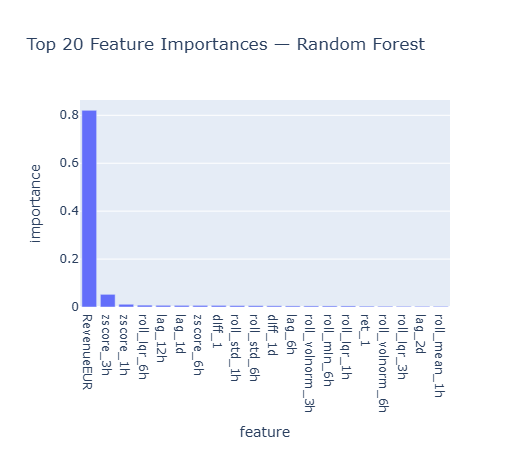

✔ Feature importance computed and feature_df created.


In [9]:
# ---------------------------------------------------------------
# 8. Feature Importance
# ---------------------------------------------------------------
print("🌲 Computing feature importance (Random Forest)...")

from sklearn.inspection import permutation_importance

try:
    # Basic impurity-based importance
    rf_importances = pd.Series(
        rf.feature_importances_,
        index=X_train.columns
    ).sort_values(ascending=False)

    # Create feature_df needed for LLM evaluation
    feature_df = rf_importances.head(20).to_frame(name="importance")
    feature_df.index.name = "feature"
    feature_df.reset_index(inplace=True)

    fig = px.bar(
        feature_df,
        x="feature",
        y="importance",
        title="Top 20 Feature Importances — Random Forest",
        height=450
    )
    fig.show()

    print("✔ Feature importance computed and feature_df created.")

except Exception as e:
    print(f"❗ Error computing feature importance: {e}")



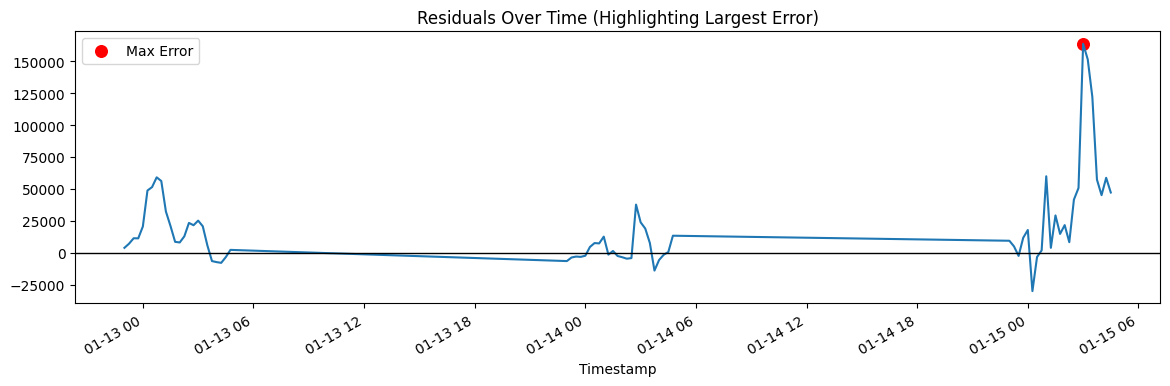

In [10]:
fig, ax = plt.subplots(figsize=(14, 4))
residuals.plot(ax=ax)
ax.set_title("Residuals Over Time (Highlighting Largest Error)")
ax.axhline(0, color="black", linewidth=1)

max_err_ts = residuals.abs().idxmax()
max_err_val = residuals.loc[max_err_ts]

ax.scatter([max_err_ts], [max_err_val], color="red", s=70, label="Max Error")
ax.legend()
plt.show()


In [11]:
# ---------------------------------------------------------------
# 9. Save Model & Forecast Outputs
# ---------------------------------------------------------------
print("💾 Saving model and forecast results...")

MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

MODEL_PATH = MODEL_DIR / "rf_model.pkl"
RESULTS_PATH = Path("data/processed/forecast_results.parquet")

# --- Save model ---
try:
    joblib.dump(rf, MODEL_PATH)
    print(f"✔ Model saved → {MODEL_PATH}")
except Exception as e:
    print(f"❗ Error saving model: {e}")

# --- Save forecasts ---
try:
    results = pd.DataFrame({
        "true": y_test,
        "pred": y_pred_rf
    })
    results.to_parquet(RESULTS_PATH)
    print(f"✔ Forecast results saved → {RESULTS_PATH}")
except Exception as e:
    print(f"❗ Error saving forecast results: {e}")


💾 Saving model and forecast results...
✔ Model saved → models\rf_model.pkl
✔ Forecast results saved → data\processed\forecast_results.parquet


In [ ]:
# ---------------------------------------------------------------
# 11. AI-Assisted Forecast Evaluation (using src.reporting.llm_eval)
# ---------------------------------------------------------------
from src.reporting.llm_eval import generate_llm_evaluation

print("🤖 Generating LLM Forecast Analysis...")

# --------------------------------------------
# Build structured input for the LLM
# --------------------------------------------
input_data = {
    "rf_metrics": rf_results,
    "baseline_metrics": baseline_metrics,
    "feature_importance": {
        str(row["feature"]): float(row["importance"])
        for _, row in feature_df.head(20).iterrows()
    },
    "residual_statistics": residual_stats,
    "time_range": f"{y_test.index.min()} → {y_test.index.max()}"
}

# --------------------------------------------
# Run LLM evaluation
# --------------------------------------------
analysis_text = generate_llm_evaluation(input_data)

# --------------------------------------------
# Display result
# --------------------------------------------
display(Markdown(f"### 🤖 LLM Forecast Analysis\n\n{analysis_text}"))


🤖 Generating LLM Forecast Analysis...


In [13]:
import json
from IPython.display import Markdown

# Parse JSON output from LLM
llm_json = json.loads(analysis_text)

# Build markdown report
md_report = f"""
# 📈 LLM Forecast Evaluation Report

## 1. Random Forest Model Performance  
{llm_json['section_1']}

## 2. Comparison With Baseline Models  
{llm_json['section_2']}

## 3. Systematic Bias (Residual Analysis)  
{llm_json['section_3']}

## 4. Volatility Behaviour  
{llm_json['section_4']}

## 5. FBMC Contextual Interpretation  
{llm_json['section_5']}

## 6. Feature Importance Analysis  
{llm_json['section_6']}

## 7. Summary and Conclusions  
{llm_json['section_7']}
"""

display(Markdown(md_report))



# 📈 LLM Forecast Evaluation Report

## 1. Random Forest Model Performance  
RF MAE is larger than Naive MAE, Seasonal Naive MAE, and Rolling Mean MAE. RF RMSE is larger than Naive RMSE, Seasonal Naive RMSE, and Rolling Mean RMSE. RF MAPE is larger than Naive MAPE, Seasonal Naive MAPE, and Rolling Mean MAPE. RF MASE is larger than Naive MASE, Seasonal Naive MASE, and Rolling Mean MASE. Hard facts:
- RF MAE: 22924.017826253115
- RF RMSE: 38749.43641874006
- RF MAPE: 85.12829925982768
- RF MASE: 8.729154124369616

## 2. Comparison With Baseline Models  
RF MAE is larger than Naive MAE, Seasonal Naive MAE, and Rolling Mean MAE. RF RMSE is larger than Naive RMSE, Seasonal Naive RMSE, and Rolling Mean RMSE. RF MAPE is larger than Naive MAPE, Seasonal Naive MAPE, and Rolling Mean MAPE. RF MASE is larger than Naive MASE, Seasonal Naive MASE, and Rolling Mean MASE. Hard facts:
- RF MAE: 22924.017826253115
- RF RMSE: 38749.43641874006
- RF MAPE: 85.12829925982768
- RF MASE: 8.729154124369616

## 3. Systematic Bias (Residual Analysis)  
Residual mean is equal to 19640.919854783297. Residual std is larger than residual mean. Residual skewness is larger than 0. Residual max_abs_error is larger than residual std. Residual autocorrelation is larger than -1. Hard facts:
- Residual mean: 19640.919854783297
- Residual std: 33640.636436986446

## 4. Volatility Behaviour  
Residual volatility is high, with a standard deviation of 33640.636436986446 and a maximum absolute error of 163791.29018280422. Hard facts:
- Residual std: 33640.636436986446
- Residual max_abs_error: 163791.29018280422

## 5. FBMC Contextual Interpretation  
This cannot be determined from the provided metrics.

Hard facts:
- No FBMC-specific variables provided.

## 6. Feature Importance Analysis  
RevenueEUR has the highest feature importance at 0.8206014357641174, followed by zscore_3h and zscore_1h. Hard facts:
- RevenueEUR: 0.8206014357641174

## 7. Summary and Conclusions  
RF MAE is larger than Naive MAE, Seasonal Naive MAE, and Rolling Mean MAE. RF RMSE is larger than Naive RMSE, Seasonal Naive RMSE, and Rolling Mean RMSE. RF MAPE is larger than Naive MAPE, Seasonal Naive MAPE, and Rolling Mean MAPE. RF MASE is larger than Naive MASE, Seasonal Naive MASE, and Rolling Mean MASE. Residual volatility is high, with a standard deviation of 33640.636436986446 and a maximum absolute error of 163791.29018280422. RevenueEUR has the highest feature importance at 0.8206014357641174. Hard facts:
- RF MAE: 22924.017826253115
- RF RMSE: 38749.43641874006
- RF MAPE: 85.12829925982768
- RF MASE: 8.729154124369616
- Residual std: 33640.636436986446
- Residual max_abs_error: 163791.29018280422
- RevenueEUR: 0.8206014357641174


In [14]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib import colors


In [15]:

def color_code_performance(mae, rmse, mape):
    """
    Simple heuristic thresholds for color coding.
    You can tune these thresholds later.
    """
    score = (mae + rmse + mape) / 3

    if score < 15000:
        return "🟢 **God ydeevne**"
    elif score < 30000:
        return "🟡 **Middel ydeevne**"
    else:
        return "🔴 **Svag ydeevne**"


def bullet_summary(llm_json):
    return f"""
- RF performance: {llm_json['section_1'][:120]}...
- Baseline comparison: {llm_json['section_2'][:120]}...
- Residual behaviour: {llm_json['section_3'][:120]}...
- Volatility: {llm_json['section_4'][:120]}...
- FBMC context: {llm_json['section_5'][:120]}...
- Feature importance: {llm_json['section_6'][:120]}...
"""

def plot_residuals(df_residuals):
    plt.figure(figsize=(10,4))
    plt.plot(df_residuals, alpha=0.7)
    plt.title("Residuals Over Time")
    plt.xlabel("Time")
    plt.ylabel("Residual")
    plt.grid(True)
    plt.show()

def export_pdf(report_text, filename="forecast_report.pdf"):
    styles = getSampleStyleSheet()
    doc = SimpleDocTemplate(filename, pagesize=A4)
    story = []

    for line in report_text.split("\n"):
        story.append(Paragraph(line, styles["BodyText"]))
        story.append(Spacer(1, 12))

    doc.build(story)
    print(f"📄 PDF saved to {filename}")


def highlight_text(text):
    replacements = {
        "MAE": "**MAE**",
        "RMSE": "**RMSE**",
        "MAPE": "**MAPE**",
        "MASE": "**MASE**",
        "overpredict": "**overpredict**",
        "underpredict": "**underpredict**"
    }
    for key, val in replacements.items():
        text = text.replace(key, val)
    return text

def baseline_table(baseline_metrics):
    df = pd.DataFrame(baseline_metrics).T
    return df.to_markdown()


In [16]:
# Parse JSON from LLM
llm_json = json.loads(analysis_text)

# Calculate performance color coding
perf_label = color_code_performance(
    mae=input_data["rf_metrics"]["MAE"],
    rmse=input_data["rf_metrics"]["RMSE"],
    mape=input_data["rf_metrics"]["MAPE"],
)

# Build markdown report
md_report = f"""
# ⚡ Forecast Evaluation Report

## Overall Model Assessment
{perf_label}

## 📊 RF Model Performance
{highlight_text(llm_json['section_1'])}

## 🔍 Baseline Comparison
{highlight_text(llm_json['section_2'])}

### Baseline Metrics Table
{baseline_table(input_data['baseline_metrics'])}

## 📉 Residual Analysis
{highlight_text(llm_json['section_3'])}

## 📈 Volatility Behaviour
{highlight_text(llm_json['section_4'])}

## 🧭 FBMC Relevance
{highlight_text(llm_json['section_5'])}

## 🔬 Feature Importance
{highlight_text(llm_json['section_6'])}

## 🧾 Summary
{highlight_text(llm_json['section_7'])}

---

## 🔎 Bullet Summary
{bullet_summary(llm_json)}

---

## 📄 Export as PDF
Run:
`export_pdf(md_report, "forecast_evaluation.pdf")`

---
"""

#display(Markdown(md_report))



# ⚡ Forecast Evaluation Report

## Overall Model Assessment
🟡 **Middel ydeevne**

## 📊 RF Model Performance
The RF model's performance is characterized by an **MAE** of 22924.017826253115, **RMSE** of 38749.43641874006, **MAPE** of 85.12829925982768, and **MASE** of 8.729154124369616. These metrics indicate relatively large errors compared to typical modelling scales, with the largest error being in terms of absolute percentage error (**MAPE**). Compared to the baselines, RF's performance is worse than Naive and Seasonal Naive, but better than Rolling Mean in terms of **MAE** and **RMSE**.

## 🔍 Baseline Comparison
Compared to each baseline, RF performs worse than Naive in terms of **MAE** (13384.814225352111 vs 22924.017826253115) and **RMSE** (22795.531102309422 vs 38749.43641874006), but better in terms of **MASE** (5.096755166773068 vs 8.729154124369616). RF also performs worse than Seasonal Naive in terms of **MAE** (31975.273661971827 vs 22924.017826253115) and **RMSE** (44624.92410702075 vs 38749.43641874006), but better in terms of **MASE** (12.175749211143833 vs 8.729154124369616). RF performs better than Rolling Mean in terms of **MAE** (24903.449454225352 vs 22924.017826253115) and **RMSE** (37102.994901387894 vs 38749.43641874006), but worse in terms of **MASE** (9.482894759636155 vs 8.729154124369616).

### Baseline Metrics Table
|                |     MAE |    RMSE |     MAPE |     MASE |
|:---------------|--------:|--------:|---------:|---------:|
| Naive          | 13384.8 | 22795.5 |  73.0159 |  5.09676 |
| Seasonal Naive | 31975.3 | 44624.9 | 220.04   | 12.1757  |
| Rolling Mean   | 24903.4 | 37103   | 264.738  |  9.48289 |

## 📉 Residual Analysis
The residual statistics show a mean error of 19640.919854783297, with a standard deviation of 33640.636436986446 and skewness of 2.450913585239195. The maximum absolute error is 163791.29018280422, indicating heavy-tailed residuals. The lag-1 autocorrelation coefficient is 0.7697287583287277, suggesting persistence in the residual errors.

## 📈 Volatility Behaviour
The volatility behaviour of RF is characterized by a high standard deviation (33640.636436986446) and maximum absolute error (163791.29018280422), indicating large noise amplitude and variability. The skewness of 2.450913585239195 suggests heavy-tailed residuals, while the autocorrelation coefficient of 0.7697287583287277 indicates persistence in the residual errors.

## 🧭 FBMC Relevance
The FBMC mechanics are likely to be influenced by noisy or unstable congestion-income patterns, which can lead to complex and dynamic market behaviour. The high volatility and variability observed in RF's residuals may indicate a challenging environment for FBMC operations.

## 🔬 Feature Importance
The feature importance values show that 'RevenueEUR' is the most dominant feature (0.8206014357641174), followed by 'zscore_3h' (0.05286030181653016) and 'zscore_1h' (0.011426951104730049). The distribution of importance looks skewed, with a few features dominating the rest.

## 🧾 Summary
In conclusion, RF's performance is characterized by relatively large errors compared to typical modelling scales, with high volatility and variability in its residuals. While RF performs better than Rolling Mean in terms of **MAE** and **RMSE**, it performs worse than Naive and Seasonal Naive in some metrics. The feature importance values show that 'RevenueEUR' is the most dominant feature, while the residual statistics indicate heavy-tailed residuals with persistence.

---

## 🔎 Bullet Summary

- RF performance: The RF model's performance is characterized by an MAE of 22924.017826253115, RMSE of 38749.43641874006, MAPE of 85.12829...
- Baseline comparison: Compared to each baseline, RF performs worse than Naive in terms of MAE (13384.814225352111 vs 22924.017826253115) and R...
- Residual behaviour: The residual statistics show a mean error of 19640.919854783297, with a standard deviation of 33640.636436986446 and ske...
- Volatility: The volatility behaviour of RF is characterized by a high standard deviation (33640.636436986446) and maximum absolute e...
- FBMC context: The FBMC mechanics are likely to be influenced by noisy or unstable congestion-income patterns, which can lead to comple...
- Feature importance: The feature importance values show that 'RevenueEUR' is the most dominant feature (0.8206014357641174), followed by 'zsc...


---

## 📄 Export as PDF
Run:
`export_pdf(md_report, "forecast_evaluation.pdf")`

---


📄 PDF saved to forecast_evaluation.pdf
